<a href="https://colab.research.google.com/github/david-meltzer/LLMs/blob/main/qlora_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/QLoRA

/content/drive/MyDrive/QLoRA


In [3]:
%ls

artifacts/                distilgpt2_sw_clean/     QLoRA.ipynb
bnb-4bit-inference.ipynb  finetuned_models/        wandb/
bnb-4bit-training.ipynb   finetuned_models_final/


In [4]:
!pip install -qqqU bitsandbytes
!pip install -qqqU git+https://github.com/huggingface/transformers.git
!pip install -qqqU git+https://github.com/huggingface/peft.git
!pip install -qqqU -U git+https://github.com/huggingface/accelerate.git
!pip install -qqqU datasets
!pip install -qqqU wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!nvidia-smi

Tue Aug  8 13:34:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from pprint import pprint

def pp(x):
  pprint(x, compact = True, width = 150)

In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#Datasets

##Download cleaned simple wiki dataset from wandb

In [ ]:
run = wandb.init()
artifact = run.use_artifact('ft-llmmm/ELI5_analysis/simple_wiki_split:v0', type='dataset')
artifact_dir = artifact.download()

wandb: Currently logged in as: baur (ft-llmmm). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact simple_wiki_split:v0, 110.97MB. 10 files... 
wandb:   10 of 10 files downloaded.  
Done. 0:0:3.3


In [ ]:
from datasets import load_from_disk
wiki = load_from_disk('artifacts/simple_wiki_split:v0')
wiki

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text', 'fre', 'fkg'],
        num_rows: 116053
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text', 'fre', 'fkg'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'text', 'fre', 'fkg'],
        num_rows: 5000
    })
})

## Cleaned simple wiki (final version)

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('ft-llmmm/ELI5_analysis/simple_wiki_split_long:v3', type='dataset')
artifact_dir = artifact.download()

wandb: Currently logged in as: baur (ft-llmmm). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact simple_wiki_split_long:v3, 129.25MB. 10 files... 
wandb:   10 of 10 files downloaded.  
Done. 0:0:4.0


In [8]:
from datasets import load_from_disk
wiki = load_from_disk('./artifacts/simple_wiki_split_long:v3')
wiki

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text', 'trunc_text', 'fre', 'fkg'],
        num_rows: 65305
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text', 'trunc_text', 'fre', 'fkg'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'text', 'trunc_text', 'fre', 'fkg'],
        num_rows: 5000
    })
})

In [9]:
wiki = wiki.filter(lambda x : '{' not in x['text'] and 'class=' not in x['text'] and 'infobox' not in x['text'])
wiki

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text', 'trunc_text', 'fre', 'fkg'],
        num_rows: 65289
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text', 'trunc_text', 'fre', 'fkg'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'text', 'trunc_text', 'fre', 'fkg'],
        num_rows: 4999
    })
})

#Tokenized datasets

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

context_len = 512
tokenizer.pad_token = tokenizer.eos_token
def tokenize(element):
    # outputs - BatchEncoding with keys: input_ids, attention_mask, length
    outputs = tokenizer(
        element["text"],
        truncation=True,
        max_length=context_len,
        return_overflowing_tokens=True,
        return_length=True,
        #padding = True,
        #return_tensors="pt",
    )

    return outputs

wiki_tokenized = wiki.map(tokenize,
                          batched = True,
                          num_proc = 4,
                          remove_columns=wiki["train"].column_names
                          )


wiki_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 80440
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 6171
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 6103
    })
})

In [11]:
wiki_tokenized['validation'] = wiki_tokenized['validation'].sort('length')
wiki_tokenized['test'] = wiki_tokenized['test'].sort('length')

In [12]:
num_examples = wiki_tokenized['train'].num_rows
num_examples

80440

##Sorted by length

In [ ]:
wiki_tokenized_sorted = wiki_tokenized.sort("length")
wiki_tokenized_sorted

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 80440
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 6171
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 6103
    })
})

Reverse sorting

In [ ]:
wiki_tokenized_sorted_reverse =  wiki_tokenized.sort("length", reverse = True)
wiki_tokenized_sorted_reverse

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 80440
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 6171
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'length', 'overflow_to_sample_mapping'],
        num_rows: 6103
    })
})

## Length statistics

In [ ]:
import numpy as np
len_stat = np.zeros((3,512))
split_names = {'train' : 0, 'test' : 1 , 'validation' : 2}
#dataset_names = {'0': 'train', '1' : 'test', '2': 'validation'}

In [ ]:
for k, v in split_names.items():
  lengths = np.array(wiki_tokenized_sorted[k]['length'])
  len_stat[v] = np.array([lengths[lengths ==n].shape[0] for n in range(1,513)] )


Plot length statistics for examples with lengths < 512

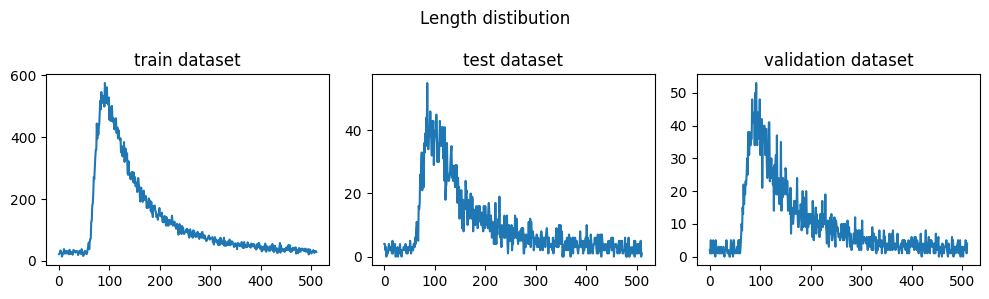

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 3))
fig.suptitle('Length distibution')

for k, v  in split_names.items():

  axs[v].plot(len_stat[v, :511])
  axs[v].set_title(k + ' dataset')

plt.tight_layout()

There are many examples with maximum length 512

In [ ]:
len_stat[ :, 511]

array([15180.,  1175.,  1106.])

#Model setup

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [14]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import torch

model_id = 'distilgpt2'

def model_setup(model_type, lora_rank=4, lora_alpha=32):
  """
  Inputs:
    model_type -- str, one of 'regular', 'lora', 'qlora'
  Outputs:
    model, (model_type, lora_rank, lora_alpha) ;  For 'regular' still outputs default lora_rank, lora_alpha that are not used.
  """

  # Define LoRA Config for either LoRA or QLoRA
  config = LoraConfig(
          r=lora_rank,
          lora_alpha=lora_alpha,
          target_modules=["wte", "wpe", "c_attn", "c_proj", "c_fc", "lm_head"],
          lora_dropout=0.05,
          bias="none",
          task_type="CAUSAL_LM"
      )

  if model_type == 'lora':
    model = AutoModelForCausalLM.from_pretrained(model_id,
                                                 load_in_8bit=True,
                                                 device_map='auto',
                                                 torch_dtype = torch.bfloat16)


    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)      # prepare int-8 model for training
    model = get_peft_model(model, config)          # add LoRA adaptor

  elif model_type == 'qlora':

    nf4_config = BitsAndBytesConfig(load_in_4bit=True,
                                    bnb_4bit_quant_type="nf4",
                                    bnb_4bit_use_double_quant=True,
                                    bnb_4bit_compute_dtype=torch.bfloat16
                                    )

    model = AutoModelForCausalLM.from_pretrained(model_id,
                                                quantization_config=nf4_config,
                                                device_map='auto',
                                                torch_dtype = torch.bfloat16
                                                )

    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, config)

  elif model_type == 'regular':
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto')

  else:
    raise ValueError('Invalid model_type')

  return model, (model_type , lora_rank, lora_alpha)

#Train

In [15]:
from transformers import DataCollatorForLanguageModeling

# needed for distilgpt2 tokenizer
tokenizer.pad_token = tokenizer.eos_token
data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [16]:
def training_args_config(model_type, lora_rank, lora_alpha):
  """
  Inputs:
    model_type -- str: 'regular', 'lora', 'qlora'
  Outputs:
    params_dict -- dict, keys correspond to kwargs of TrainingArguments
  """
  #Common hyperparameters

  params = {

  #training
  'num_train_epochs' : 1,
  'learning_rate' : 5e-4,
  'weight_decay' : 0.01,
  'dataloader_num_workers' : 4,
  'per_device_train_batch_size' : 64,   #default is 8
  #'auto_find_batch_size' : True,
  'per_device_eval_batch_size' : 64,
  'group_by_length' : True,
  #'lr_scheduler_type' : 'constant',

  #efficient training
  'gradient_accumulation_steps' : 4,
  'gradient_checkpointing' : True,
  #"warmup_steps' - defined below


  #logging
  'report_to' : "wandb",
  'output_dir' : "finetuned_models_final/tuned_from_checkpoint",
  'evaluation_strategy' : "epoch",
  'logging_strategy' : 'epoch',
  #'eval_steps' : (num_examples // (per_device_train_batch_size * gradient_accumulation_steps) ) // 10 ,  #evaluate 10 times during training
  #'logging_steps' : eval_steps,
  'save_strategy' : "epoch",
  #'save_steps' : 5*eval_steps,
  'save_total_limit' : 10,


  'load_best_model_at_end' : True,
  'metric_for_best_model' : "eval_loss",
  'greater_is_better' : False,
  }

  #total_steps = params['num_train_epochs'] * params['per_device_train_batch_size'] * params['gradient_accumulation_steps']
  #total_steps = params['num_train_epochs'] * 64 * params['gradient_accumulation_steps']
  #num_evals = 5  # evaluate 5 times during training

  #params['warmup_steps'] = (num_examples // total_steps) // 10  # warmup for 10% of total steps
  #params['eval_steps'] = (num_examples // total_steps) // num_evals
  #params['logging_steps'] = params['eval_steps']
  #params['save_steps'] =  params['eval_steps']


  if model_type == 'lora' or model_type =='qlora':
    params['adafactor'] = False
    params['optim'] = "paged_adamw_8bit"
    params['fp16'] = False
    params['bf16'] = True

    params['run_name'] = f'{model_type}, r={lora_rank}, alpha = {lora_alpha}'

  elif model_type == 'regular':
    params['adafactor'] = True
    #params['optim'] = "paged_adamw_8bit"
    params['fp16'] = False
    params['bf16'] = True

    params['run_name'] = f'{model_type}, lr={  params["learning_rate"] } , wd = { params["weight_decay"] }'

  else:
    raise ValueError('Invalid model_type')

  return params


In [ ]:
from transformers import TrainingArguments, Trainer

model_type = 'qlora'         # 'regular', 'lora', 'qlora'
model, (model_type, lora_rank, lora_alpha) = model_setup(model_type,
                                                        lora_rank =32,
                                                        lora_alpha = 32
                                                        )

hyperparams = training_args_config(model_type, lora_rank, lora_alpha)
pp(hyperparams)

%env WANDB_PROJECT=distilgpt2_simplewiki_b
WANDB_LOG_MODEL="checkpoint"   #another option is 'checkpoint'

trainer = Trainer(model = model,
                  args = TrainingArguments(**hyperparams),
                  train_dataset = wiki_tokenized["train"],
                  eval_dataset = wiki_tokenized["validation"],
                  data_collator = data_collator,
                  )

trainer.train()
wandb.finish()


## Load and train from a checkpoint

In [18]:
from peft import PeftModel, PeftConfig

def qlora_from_checkpoint(path, model_id = 'distilgpt2'):

  nf4_config = BitsAndBytesConfig(load_in_4bit=True,
                                      bnb_4bit_quant_type="nf4",
                                      bnb_4bit_use_double_quant=True,
                                      bnb_4bit_compute_dtype=torch.bfloat16
                                      )

  base_model = AutoModelForCausalLM.from_pretrained(model_id,
                                              quantization_config=nf4_config,
                                              device_map='auto',
                                              torch_dtype = torch.bfloat16
                                              )


  base_model.gradient_checkpointing_enable()
  base_model = prepare_model_for_kbit_training(base_model)

  model = PeftModel.from_pretrained(model = base_model,
                    model_id = path,
                    torch_dtype = torch.bfloat16,
                    is_trainable = True)

  return model

In [ ]:
#Train from checkpoints at [3,5,7] epochs

checkpoint_ids = [942,1571,2199]

for id in checkpoint_ids:
  model = qlora_from_checkpoint(f'./finetuned_models_final/checkpoint-{id}')
  %env WANDB_PROJECT=distilgpt2_simplewiki_b
  WANDB_LOG_MODEL="checkpoint"

  trainer = Trainer(model = model,
                    args = TrainingArguments(**hyperparams),
                    train_dataset = wiki_tokenized["train"],
                    eval_dataset = wiki_tokenized["validation"],
                    data_collator = data_collator,
                    )

  trainer.train()
  wandb.finish()